# Check tensorflow and the avability of GPUs

In [1]:
# %tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
### Copy the weights and configurations for the pre-trained models

# Data preparation

In [3]:
dataset_directory  = "/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images"

In [4]:
!pip install sklearn

In [5]:
from glob import glob
from sklearn.model_selection import train_test_split

In [6]:
distinct_labels = [
  '0 No_DR',
  '1 Mild',
  '2 Moderate',
  '3 Severe',
  '4 Proliferate_DR'
]

In [7]:
import os
images_directory = os.path.join(dataset_directory, 'all')

In [8]:
import os
def read_images(images_directory):
    images = []
    labels = []

    for label in os.listdir(images_directory):
        if label not in ['.DS_Store']:
            label_number = distinct_labels.index(label)
            labeled_image_path = os.path.join(images_directory, label)
            labeled_images = [os.path.join(labeled_image_path, image) for image in os.listdir(labeled_image_path)]
            images.extend(labeled_images)
            labels.extend([label_number] * len(labeled_images))
    return images, labels

In [9]:
images, labels = read_images(images_directory)

### Plot some random images from the dataset.

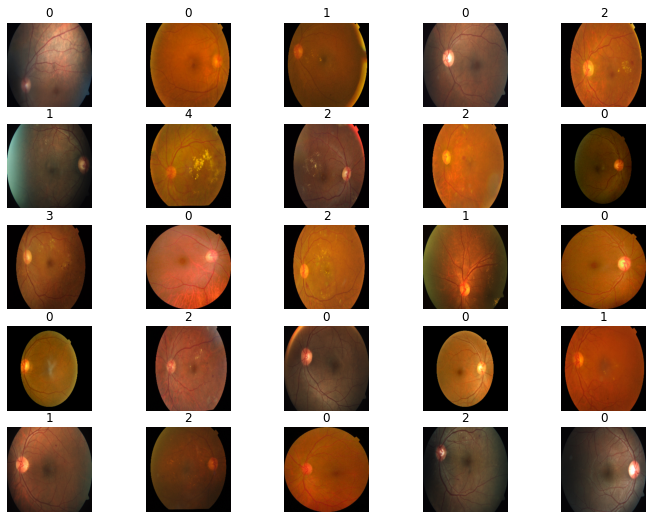

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

random_data_indices = np.random.choice(list(range(len(images))), 25)
sample_data = [images[i] for i in random_data_indices]
sample_labels = [labels[i] for i in random_data_indices]

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(sample_data, sample_labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

# Model customization

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

In [12]:
CLASSES = len(distinct_labels)
    
# setup model
base_model = VGG19(weights='imagenet', include_top=False)
x = VGG19(weights='imagenet', include_top=True)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
#x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 32

TRAIN_DIR = os.path.join(dataset_directory, 'train')
TEST_DIR = os.path.join(dataset_directory, 'test')

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2929 images belonging to 5 classes.
Found 733 images belonging to 5 classes.


Plot some images result of data augmentation.

In [15]:
!pip install SciPy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

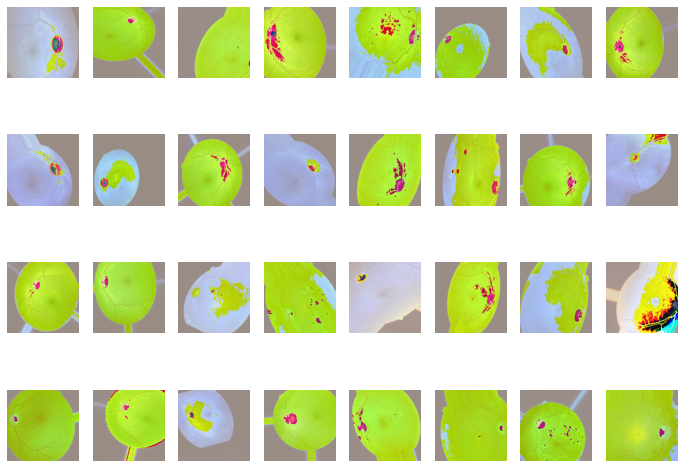

In [16]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')

# Transfer learning

In [17]:
EPOCHS =50
BATCH_SIZE = 32
STEPS_PER_EPOCH = 90
VALIDATION_STEPS = 20

MODEL_FILE = 'vgg19.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

<ipython-input-17-5e9813237467>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
90/90 [==============================] - 22s 235ms/step - loss: 1.4319 - accuracy: 0.5808 - val_loss: 1.2634 - val_accuracy: 0.5766
Epoch 2/50
90/90 [==============================] - 21s 232ms/step - loss: 0.9725 - accuracy: 0.6785 - val_loss: 0.9834 - val_accuracy: 0.6656
Epoch 3/50
90/90 [==============================] - 21s 233ms/step - loss: 0.8491 - accuracy: 0.7037 - val_loss: 0.8669 - val_accuracy: 0.7016
Epoch 4/50
90/90 [==============================] - 21s 232ms/step - loss: 0.7726 - accuracy: 0.7239 - val_loss: 0.9033 - val_accuracy: 0.6797
Epoch 5/50
90/90 [==============================] - 21s 232ms/step - loss: 0.7627 - accuracy: 0.7229 - val_loss: 0.7858 - val_accuracy: 0.7359
Epoch 6/50
90/90 [==============================] - 21s 233ms/step - loss: 0.7082 - accuracy: 0.7438 - val_loss: 0.8325 - val_accuracy: 0.7219
Epoch 7/50
90/90 [==============================] - 21s 232ms/step - loss: 0.6799 - accuracy: 0.7469 - val_loss: 0.8033 - val_accuracy: 0.6984

In [18]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r')
#   plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r')
#   plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()


In [19]:
len(history.history['accuracy'])

50

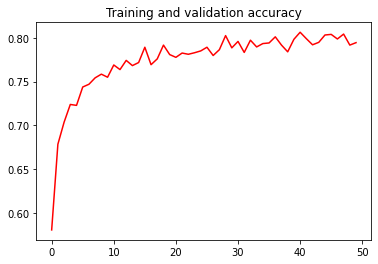

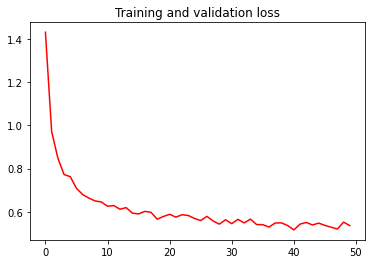

In [20]:
plot_training(history)

# Prediction of the custom model

### Split Data into Training and Validation

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model

def process_image(image_path):
    img = image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    return img_data

def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    label_numbers = list(range(len(distinct_labels)))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh(label_numbers, preds, alpha=0.5)
    plt.yticks(label_numbers, distinct_labels)
    plt.xlabel('Probability')
    plt.tight_layout()

In [22]:
model = load_model(MODEL_FILE)

In [23]:
def predict_and_plot(image_path):
    print(image_path)
    img = image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    preds = predict(model, img)

    plot_preds(img, preds)
    return preds

In [24]:
import random

def test_label_prediction(label, limit):
    test_severe_images = [os.path.join(TEST_DIR, label, image) for image in os.listdir(os.path.join(TEST_DIR, label))]
    random.shuffle(test_severe_images)
    sample = test_severe_images[:limit]
    for image in sample:
        predict_and_plot(image)

/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/0 No_DR/58c12863f33d.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/0 No_DR/53327edb9e4d.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/0 No_DR/668a319c2d23.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/0 No_DR/6b91e99c9408.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/0 No_DR/10f6ef37fe43.png


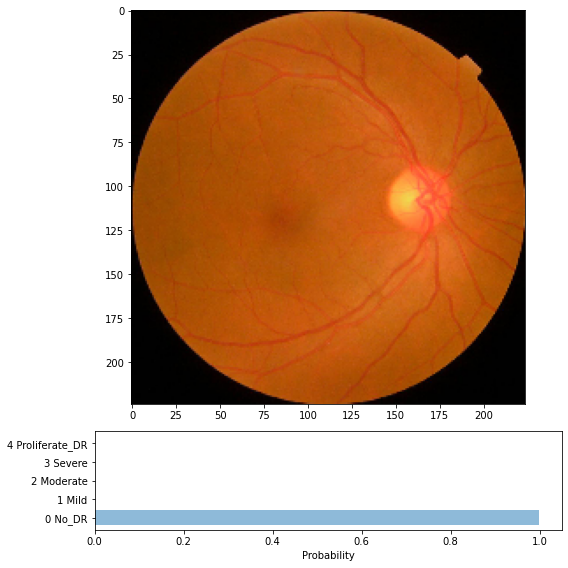

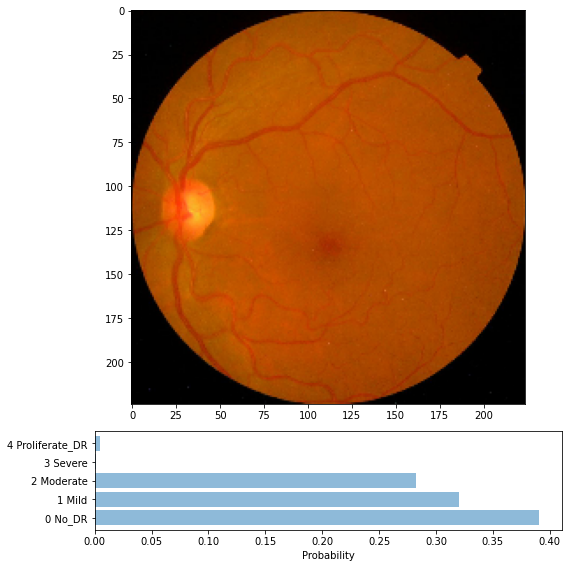

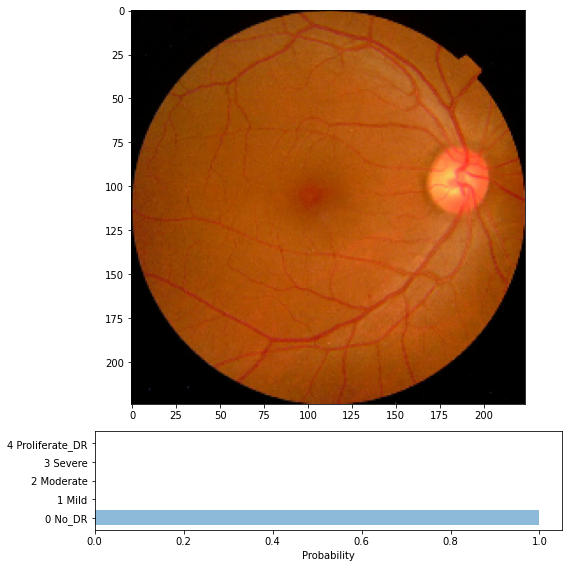

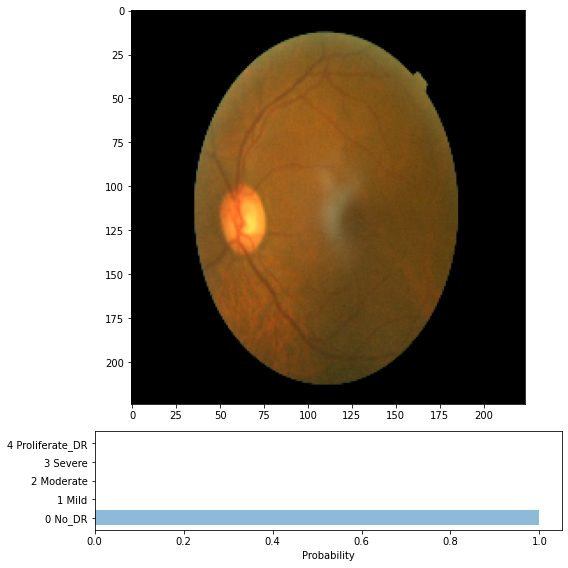

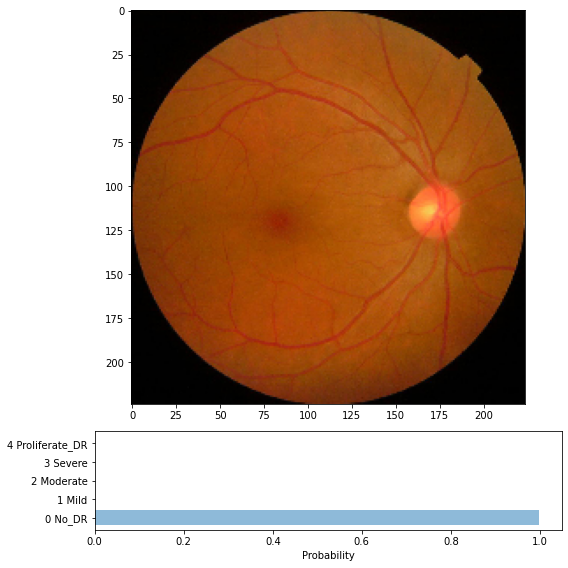

In [25]:
# testing some Severe labeled images
test_label_prediction('0 No_DR', 5)

/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/1 Mild/6165081b9021.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/1 Mild/e07045d7c5f7.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/1 Mild/513b0a4651fa.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/1 Mild/9ed666e982cd.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/1 Mild/f5650eb52640.png


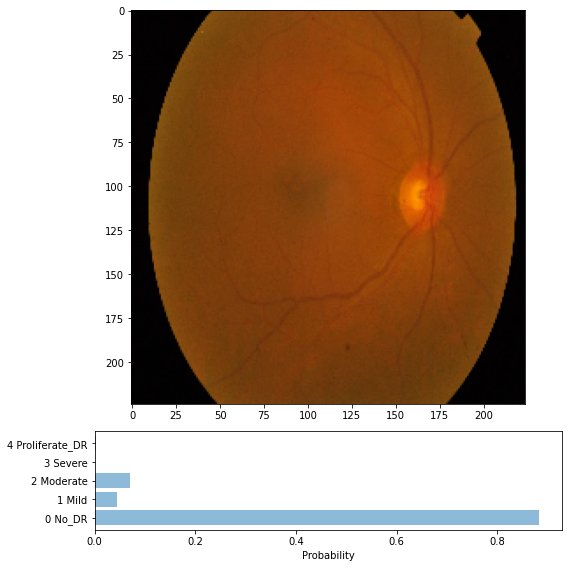

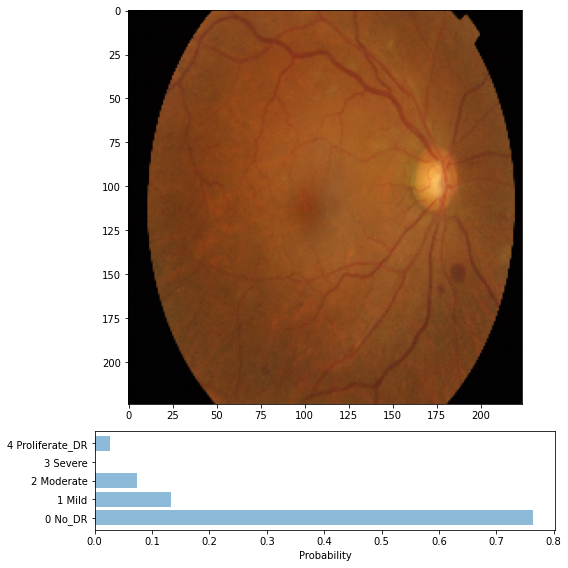

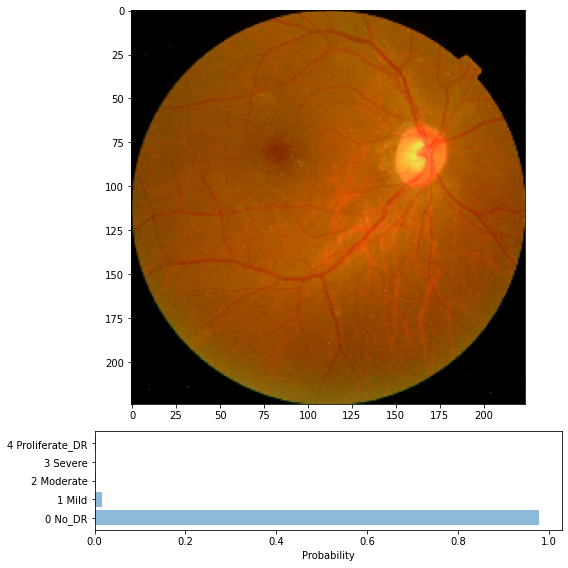

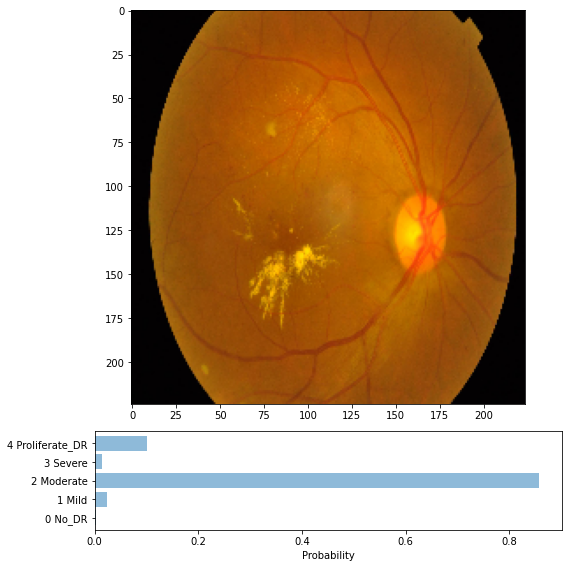

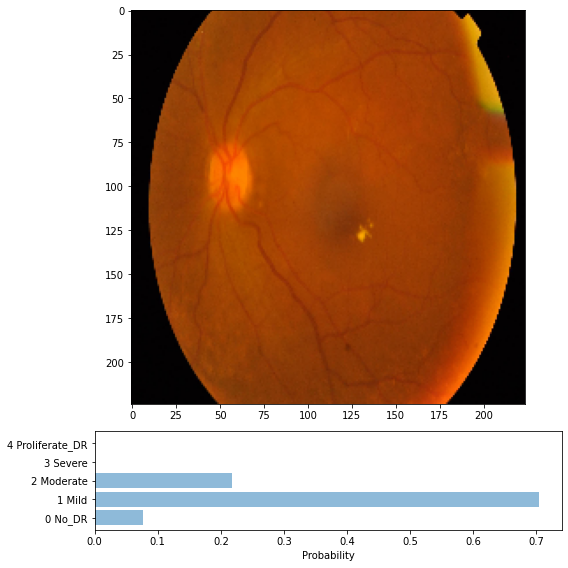

In [26]:
# testing some Severe labeled images
test_label_prediction('1 Mild', 5)

/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/2 Moderate/d41b33fcb94f.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/2 Moderate/caec68f11c86.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/2 Moderate/31b5d6fb0256.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/2 Moderate/04a6fc58dabc.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/2 Moderate/b574d229ec4c.png


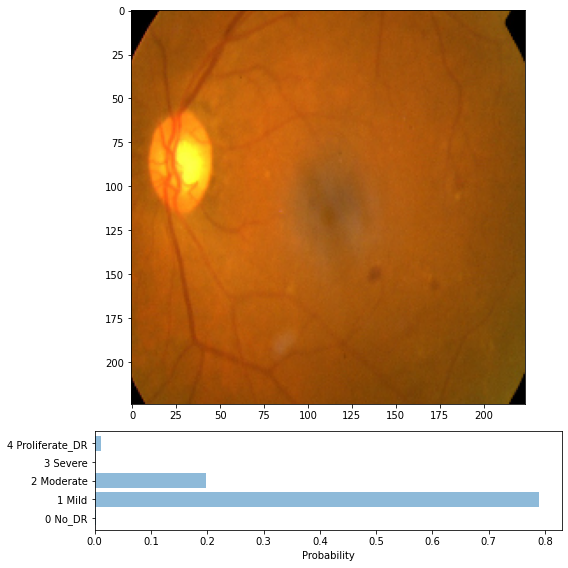

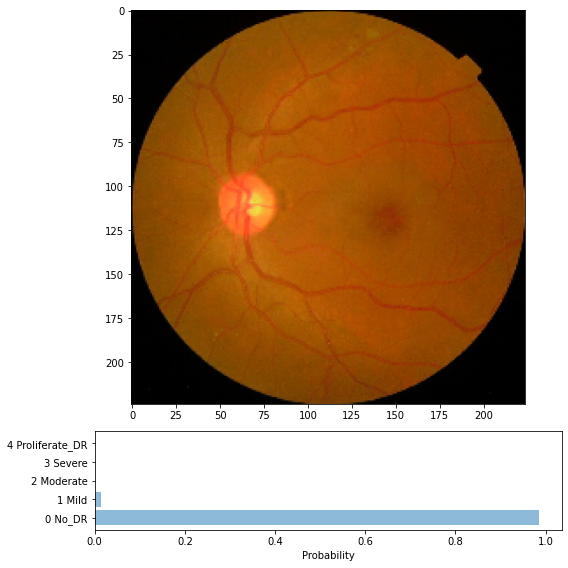

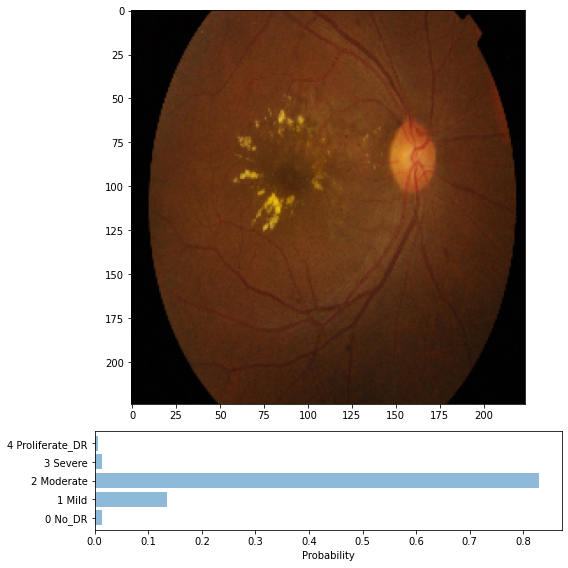

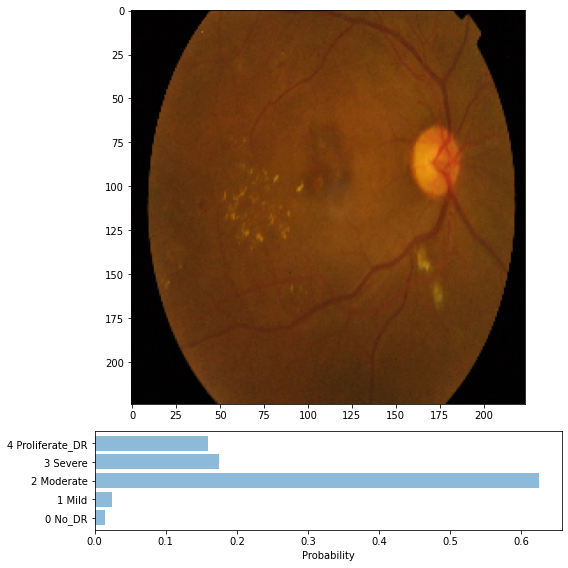

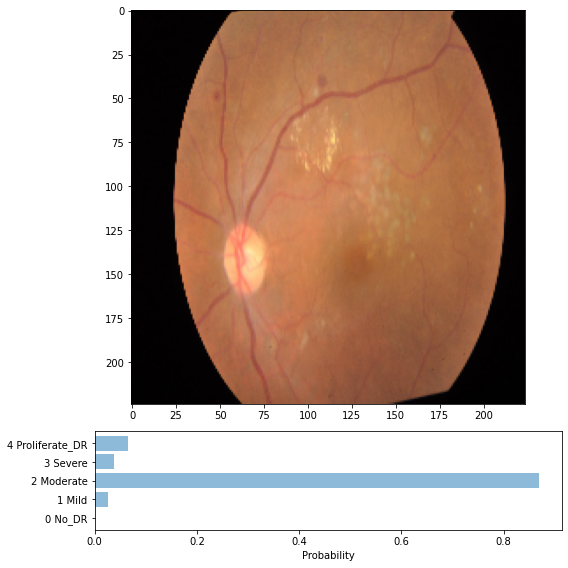

In [27]:
# testing some Severe labeled images
test_label_prediction('2 Moderate', 5)

/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/3 Severe/9a94e0316ee3.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/3 Severe/8688f3d0fcaf.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/3 Severe/0c917c372572.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/3 Severe/e8d1c6c07cf2.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/3 Severe/6fb656d506b2.png


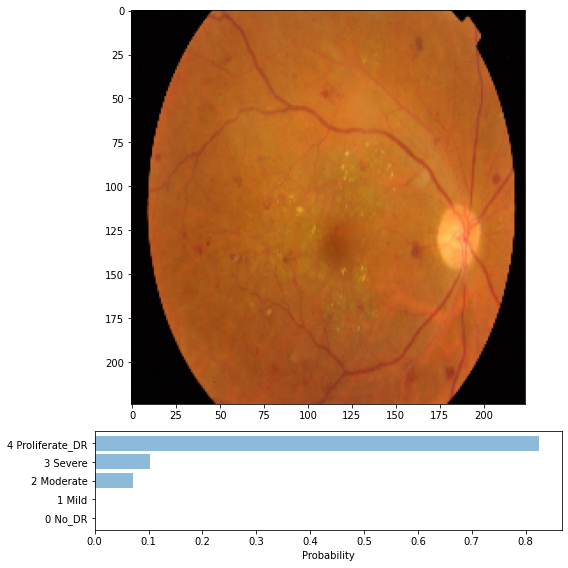

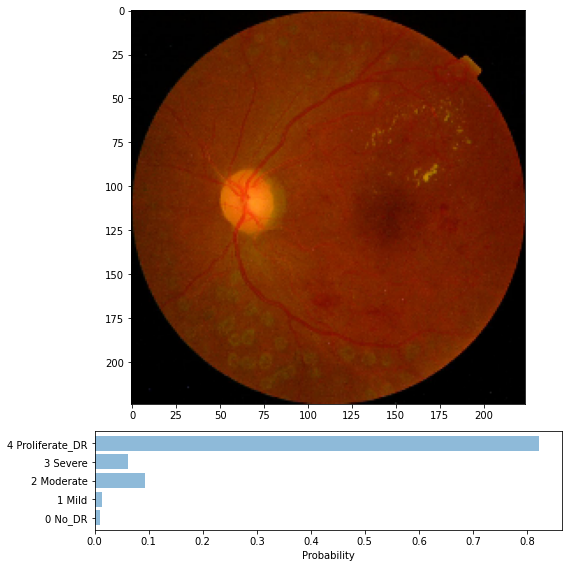

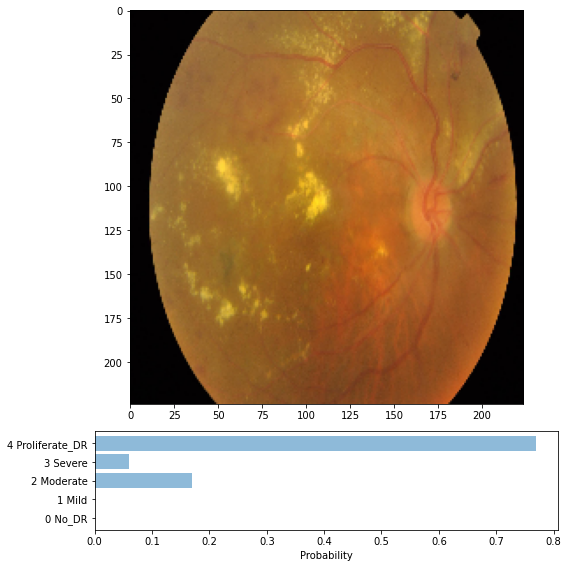

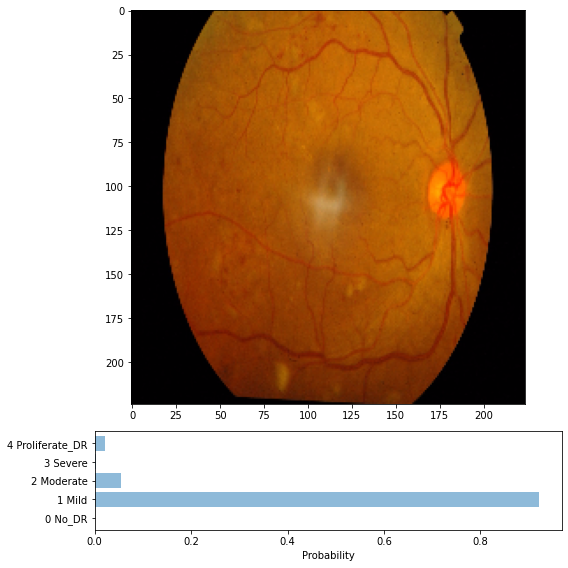

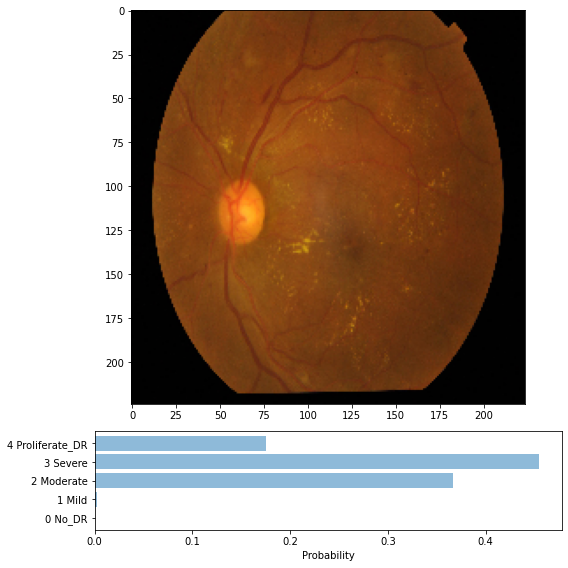

In [28]:
# testing some Severe labeled images
test_label_prediction('3 Severe', 5)

/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/4 Proliferate_DR/1b32e1d775ea.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/4 Proliferate_DR/1e9224ccca95.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/4 Proliferate_DR/27e2be850a99.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/4 Proliferate_DR/e4f12411fd85.png
/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images/test/4 Proliferate_DR/3b232b394e4f.png


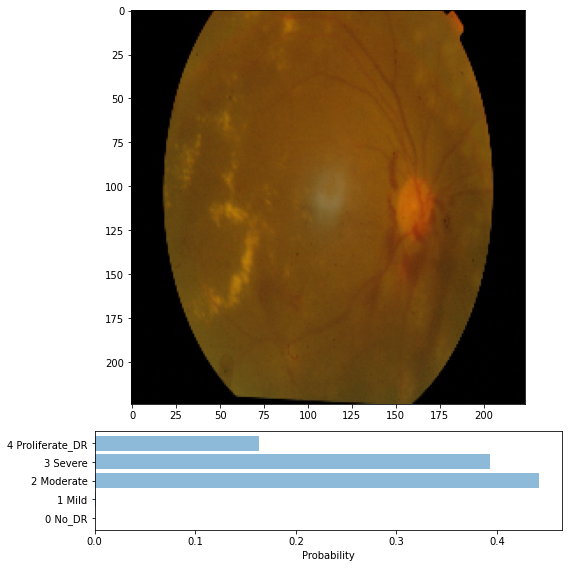

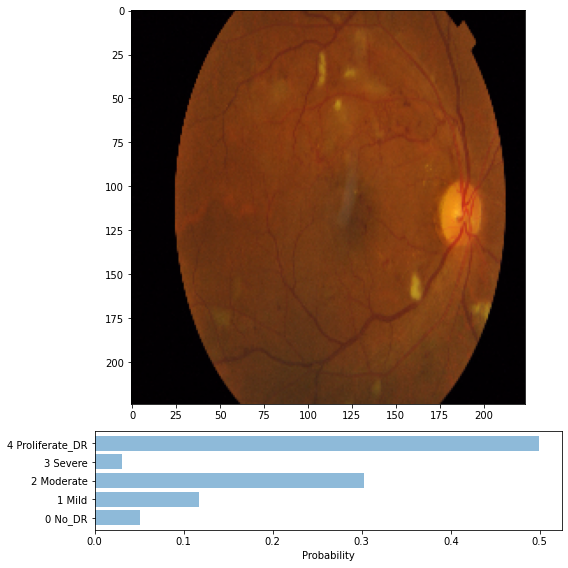

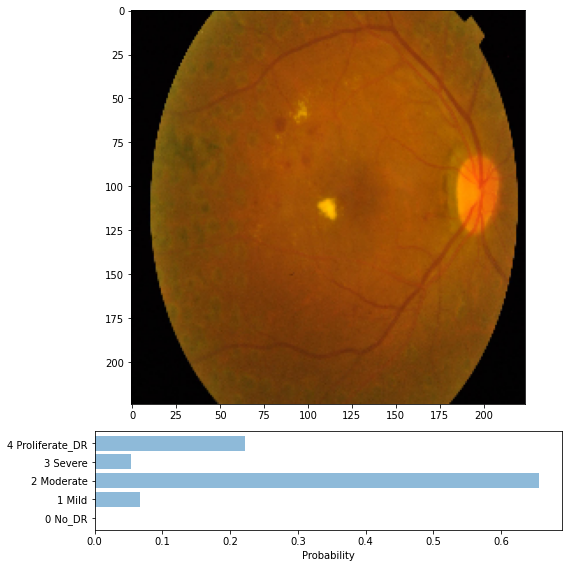

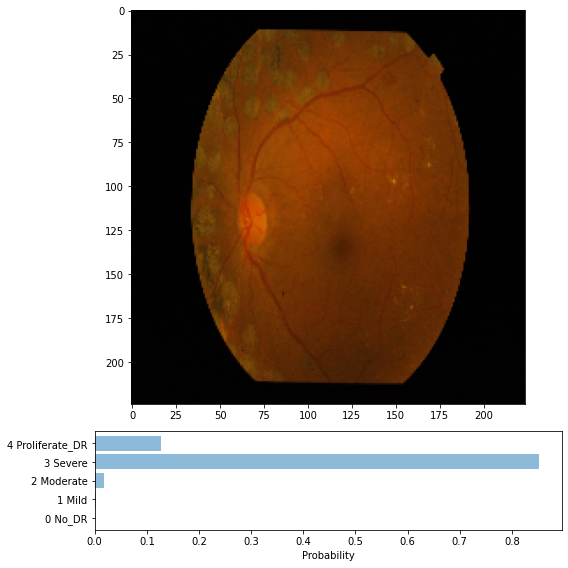

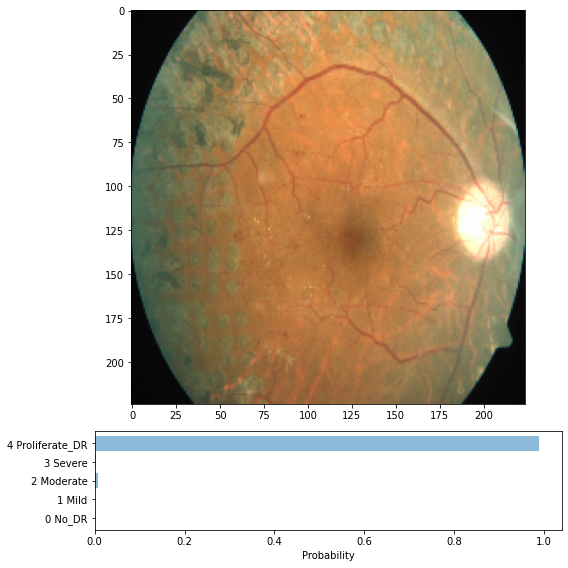

In [29]:
# testing some Severe labeled images
test_label_prediction('4 Proliferate_DR', 5)

In [30]:
test_images_path, test_labels = read_images(TEST_DIR)

In [31]:
len(test_images_path)

733

In [32]:
test_images = [process_image(path) for path in test_images_path]

In [33]:
predictions = model.predict(test_images[0])[0]

In [34]:
predictions

array([9.3749495e-06, 1.5858004e-03, 3.7580496e-03, 1.3316643e-03,
       9.9331516e-01], dtype=float32)

In [35]:
np.where(predictions == max(predictions))[0][0]

4

In [36]:
predicted_labels = []
for image in test_images:
    probabilities = model.predict(image)[0]
    predicted_label = np.where(probabilities == max(probabilities))[0][0]
    predicted_labels.append(predicted_label)

In [37]:
import tensorflow as tf
confusion = tf.math.confusion_matrix(labels=test_labels, predictions=predicted_labels, num_classes=len(distinct_labels))

In [38]:
confusion

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[353,   6,   2,   0,   0],
       [ 21,  33,  19,   0,   1],
       [ 18,  31, 118,  13,  20],
       [  0,   3,  13,  18,   5],
       [  3,   7,  18,   5,  26]], dtype=int32)>

In [39]:
print(distinct_labels)

['0 No_DR', '1 Mild', '2 Moderate', '3 Severe', '4 Proliferate_DR']


In [40]:
correct_predictions = [np.array(confusion)[i][i] for i in range(len(distinct_labels))]

In [41]:
list(zip(distinct_labels, correct_predictions))

[('0 No_DR', 353),
 ('1 Mild', 33),
 ('2 Moderate', 118),
 ('3 Severe', 18),
 ('4 Proliferate_DR', 26)]